### Import required libraies

In [ ]:
import os, json
import numpy as np
import pandas as pd
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
from tensorflow.keras import models

### Config (match training setup)

In [10]:
CSV_PATH = "mitbih_final_complete_features.csv"
ARTIFACTS_PATH = os.path.join("saved_models", "artifacts.json")
RAW_SIGNAL_LEN = 200
SAMPLES_PER_CLASS = 3  # 3 Normal + 3 Abnormal
RANDOM_STATE = 123

W_META = 0.5
W_HYBRID = 0.5

### Load data

In [11]:
df = pd.read_csv(CSV_PATH)
print(f"Loaded dataset: {df.shape[0]} rows, {df.shape[1]} columns")

Loaded dataset: 112551 rows, 211 columns


### Load artifacts

In [12]:
with open(ARTIFACTS_PATH, "r") as f:
    artifacts = json.load(f)

scaler = joblib.load(artifacts["scaler_tab"])
rf = joblib.load(artifacts["rf_full"])
xgb = joblib.load(artifacts["xgb_full"])
lgbm = lgb.Booster(model_file=artifacts["lgb_full"])
meta_lr = joblib.load(artifacts["meta_lr"])
hybrid = models.load_model(artifacts["hybrid_best"])

label_map = {}
if os.path.exists(artifacts.get("label_mapping", "")):
    label_map = json.load(open(artifacts["label_mapping"]))

C:\Users\Thinkpad\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Thinkpad\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Thinkpad\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.5.1. Th

### Feature columns

In [13]:
signal_cols = [str(i) for i in range(RAW_SIGNAL_LEN)]
tabular_candidates = ['mean','std','min','max','energy','skewness','kurtosis',
                      'r_peak_amplitude','rr_interval_sec','spectral_energy']
tab_cols = [c for c in tabular_candidates if c in df.columns]

### Map lables to binary

In [14]:
NORMAL_SYMBOLS = set(label_map.get("normal_symbols", ['N','L','R','e','j']))
df['binary_label'] = df['label'].astype(str).apply(lambda s: 0 if s in NORMAL_SYMBOLS else 1)

### Sample 3 Normal + 3 Abnormal

In [15]:
np.random.seed(RANDOM_STATE)
normal_samples = df[df['binary_label'] == 0].sample(SAMPLES_PER_CLASS, random_state=RANDOM_STATE)
abnormal_samples = df[df['binary_label'] == 1].sample(SAMPLES_PER_CLASS, random_state=RANDOM_STATE)
samples = pd.concat([normal_samples, abnormal_samples]).reset_index(drop=True)

print(f"Selected {SAMPLES_PER_CLASS} Normal and {SAMPLES_PER_CLASS} Abnormal samples.")
print(samples[['label', 'binary_label']])

Selected 3 Normal and 3 Abnormal samples.
  label  binary_label
0     L             0
1     R             0
2     N             0
3     V             1
4     V             1
5     V             1


### Prediction

In [16]:
results = []
for i, row in samples.iterrows():
    idx = int(row.name)
    symbol = str(row['label'])
    true_label = int(row['binary_label'])

    sig = row[signal_cols].values.astype(np.float32)
    tab = row[tab_cols].fillna(0).values.astype(np.float32)
    tab_scaled = scaler.transform(tab.reshape(1, -1))
    sig_input = sig.reshape(1, RAW_SIGNAL_LEN, 1)

    # Base model probabilities
    p_rf = rf.predict_proba(tab_scaled)[:, 1][0]
    p_xgb = xgb.predict_proba(tab_scaled)[:, 1][0]
    p_lgb = lgbm.predict(tab_scaled)[0]

    meta_input = np.array([[p_rf, p_xgb, p_lgb]])
    p_meta = meta_lr.predict_proba(meta_input)[:, 1][0]

    try:
        p_hybrid = hybrid.predict({"signal_input": sig_input, "tab_input": tab_scaled}, verbose=0)[0, 0]
    except Exception:
        p_hybrid = hybrid.predict([sig_input, tab_scaled], verbose=0)[0, 0]

    p_final = W_META * p_meta + W_HYBRID * p_hybrid
    pred_final = int(p_final >= 0.5)

    results.append({
        "index": idx,
        "symbol": symbol,
        "true_label": true_label,
        "p_rf": p_rf,
        "p_xgb": p_xgb,
        "p_lgb": p_lgb,
        "p_meta": p_meta,
        "p_hybrid": p_hybrid,
        "p_final": p_final,
        "pred_final": pred_final
    })

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_1368\1484966688.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tab = row[tab_cols].fillna(0).values.astype(np.float32)
C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_1368\1484966688.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tab = row[tab_cols].fillna(0).values.astype(np.float32)
C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_1368\1484966688.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_object

### Results

In [17]:
res_df = pd.DataFrame(results)
res_df['true_label_name'] = res_df['true_label'].map({0: "Normal", 1: "Abnormal"})
res_df['pred_label_name'] = res_df['pred_final'].map({0: "Normal", 1: "Abnormal"})

print("\nPrediction Summary (6 samples):")
print(res_df[['symbol', 'true_label_name', 'p_meta', 'p_hybrid', 'p_final', 'pred_label_name']].to_string(index=False))


Prediction Summary (6 samples):
symbol true_label_name   p_meta  p_hybrid  p_final pred_label_name
     L          Normal 0.012073  0.000006 0.006040          Normal
     R          Normal 0.014467  0.000058 0.007263          Normal
     N          Normal 0.012170  0.000094 0.006132          Normal
     V        Abnormal 0.992581  0.999999 0.996290        Abnormal
     V        Abnormal 0.662328  0.999991 0.831160        Abnormal
     V        Abnormal 0.993414  0.999996 0.996705        Abnormal


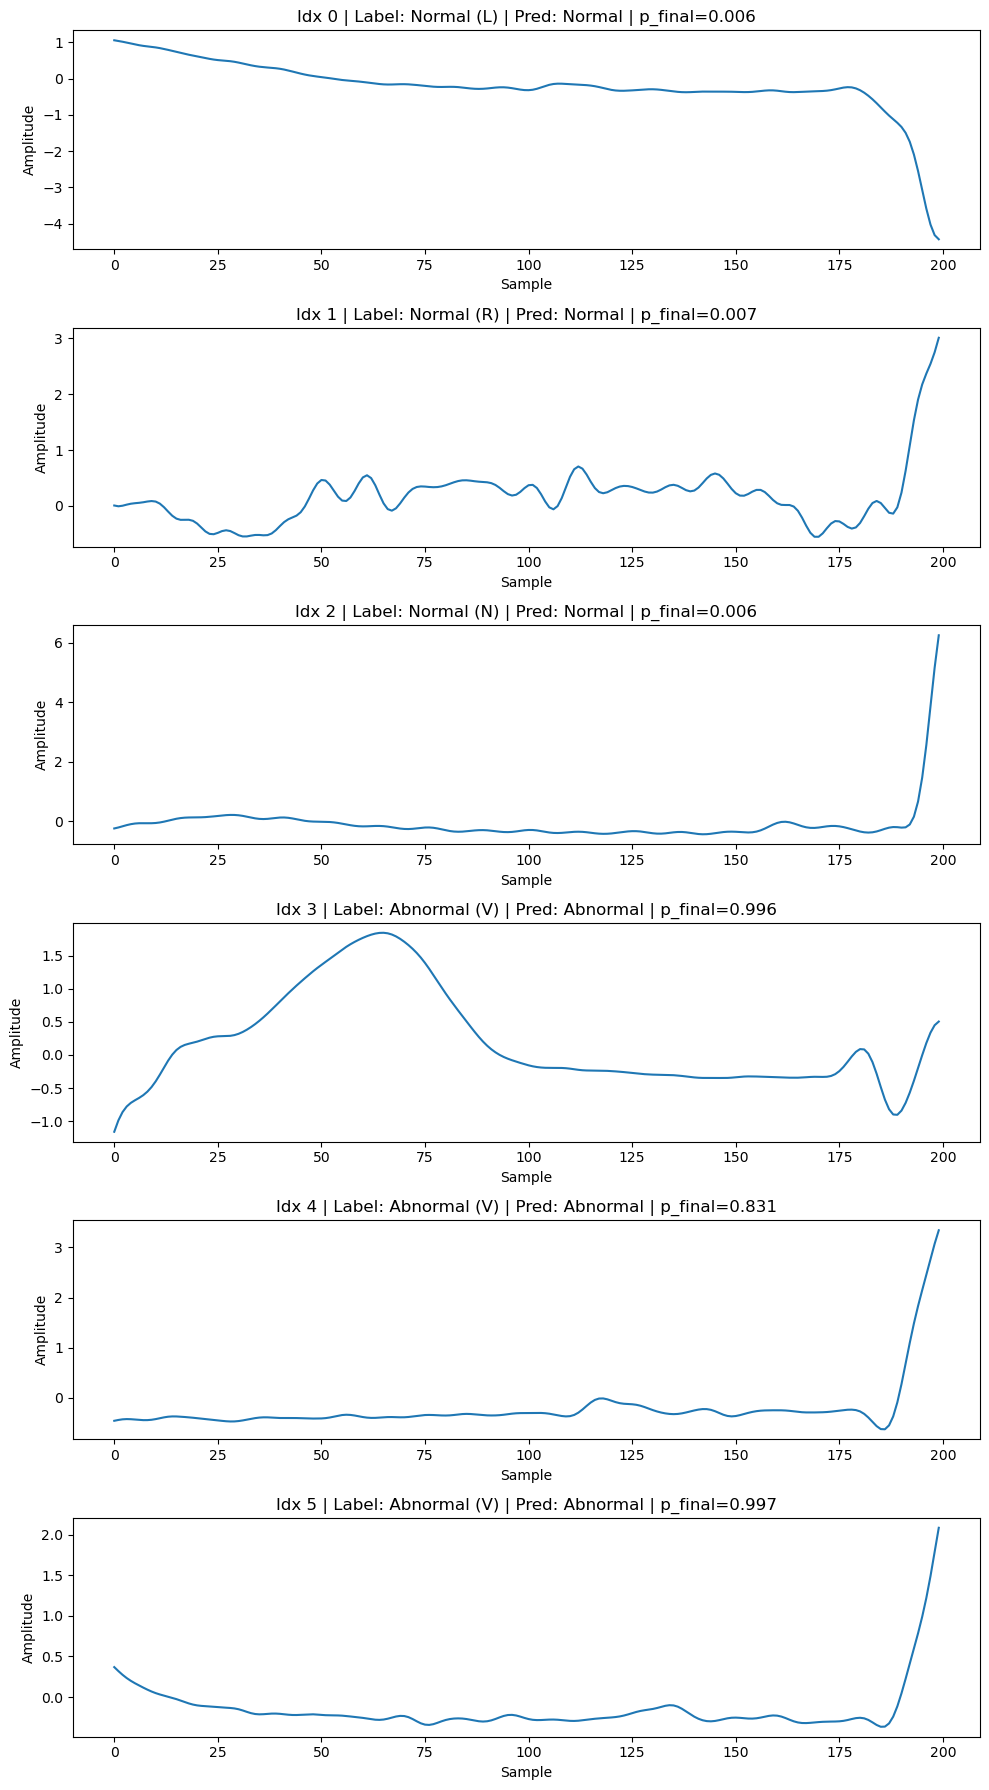

In [18]:
# -------- PLOT THE SIGNALS --------
fig, axs = plt.subplots(len(samples), 1, figsize=(10, 3 * len(samples)))
if len(samples) == 1:
    axs = [axs]

for ax, (i, row) in zip(axs, samples.iterrows()):
    sig = row[signal_cols].values.astype(np.float32)
    info = res_df.iloc[i]
    ax.plot(np.arange(len(sig)), sig)
    ax.set_title(
        f"Idx {info['index']} | Label: {info['true_label_name']} ({info['symbol']}) | "
        f"Pred: {info['pred_label_name']} | p_final={info['p_final']:.3f}"
    )
    ax.set_xlabel("Sample")
    ax.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

### Functions for prediction

In [20]:
import os
import json
import numpy as np
import pandas as pd
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Dict, Any
from tensorflow.keras import models

In [21]:
def load_artifacts(artifacts_path: str) -> Dict[str, Any]:
    """
    Load saved model artifacts and preprocessors from artifacts.json manifest.
    Returns a dict with loaded objects and file paths (keys: scaler, rf, xgb, lgbm, meta_lr, hybrid, label_mapping).
    """
    with open(artifacts_path, "r") as f:
        artifacts = json.load(f)

    out = {}
    # scaler
    out['scaler'] = joblib.load(artifacts['scaler_tab'])
    # sklearn models
    out['rf'] = joblib.load(artifacts['rf_full'])
    out['xgb'] = joblib.load(artifacts['xgb_full'])
    # lightgbm booster
    out['lgbm'] = lgb.Booster(model_file=artifacts['lgb_full'])
    out['meta_lr'] = joblib.load(artifacts['meta_lr'])
    # keras model
    out['hybrid'] = models.load_model(artifacts['hybrid_best'])
    # label mapping (optional)
    out['label_mapping'] = {}
    if os.path.exists(artifacts.get("label_mapping", "")):
        out['label_mapping'] = json.load(open(artifacts["label_mapping"]))
    # also keep manifest for reference
    out['manifest'] = artifacts
    return out

In [22]:
def test_saved_models_on_samples(
    csv_path: str,
    artifacts_path: str,
    samples_per_class: int = 3,
    raw_signal_len: int = 200,
    random_state: int = 123,
    w_meta: float = 0.5,
    w_hybrid: float = 0.5,
    plot: bool = True
) -> pd.DataFrame:
    """
    Selects samples_per_class Normal and Abnormal beats from csv_path, runs saved models
    (loaded from artifacts_path), returns a DataFrame with probabilities and final predictions.
    Optionally plots the ECG traces.

    Returns:
        pandas.DataFrame with columns:
          ['index','symbol','true_label','p_rf','p_xgb','p_lgb','p_meta','p_hybrid','p_final','pred_final']
    """
    # Load data
    df = pd.read_csv(csv_path)
    print(f"Loaded dataset: {df.shape[0]} rows, {df.shape[1]} columns")

    # Load models & artifacts
    artifacts = load_artifacts(artifacts_path)
    scaler = artifacts['scaler']
    rf = artifacts['rf']
    xgb = artifacts['xgb']
    lgbm = artifacts['lgbm']
    meta_lr = artifacts['meta_lr']
    hybrid = artifacts['hybrid']
    label_map = artifacts.get('label_mapping', {})

    # Columns
    signal_cols = [str(i) for i in range(raw_signal_len)]
    tabular_candidates = [
        'mean','std','min','max','energy','skewness','kurtosis',
        'r_peak_amplitude','rr_interval_sec','spectral_energy'
    ]
    tab_cols = [c for c in tabular_candidates if c in df.columns]
    if len(tab_cols) == 0:
        raise RuntimeError("No tabular feature columns found in CSV. Adjust tabular_candidates.")

    # Build binary label column
    normal_symbols = set(label_map.get("normal_symbols", ['N','L','R','e','j']))
    df['binary_label'] = df['label'].astype(str).apply(lambda s: 0 if s in normal_symbols else 1)

    # Sample
    rng = np.random.RandomState(random_state)
    normal_df = df[df['binary_label'] == 0]
    abnormal_df = df[df['binary_label'] == 1]
    if len(normal_df) < samples_per_class or len(abnormal_df) < samples_per_class:
        raise ValueError("Not enough samples in one of the classes to sample the requested amount.")

    normal_samples = normal_df.sample(samples_per_class, random_state=random_state)
    abnormal_samples = abnormal_df.sample(samples_per_class, random_state=random_state)
    samples = pd.concat([normal_samples, abnormal_samples]).reset_index(drop=False)  # keep original index in 'index' column
    samples = samples.rename(columns={'index':'orig_index'})

    # Predict
    results = []
    for _, row in samples.iterrows():
        orig_idx = int(row['orig_index'])
        symbol = str(row['label'])
        true_label = int(row['binary_label'])

        sig = row[signal_cols].values.astype(np.float32)
        tab = row[tab_cols].fillna(0).values.astype(np.float32)
        tab_scaled = scaler.transform(tab.reshape(1, -1))
        sig_input = sig.reshape(1, raw_signal_len, 1)

        # Base model probabilities
        p_rf = float(rf.predict_proba(tab_scaled)[:,1][0])
        p_xgb = float(xgb.predict_proba(tab_scaled)[:,1][0])
        p_lgb = float(lgbm.predict(tab_scaled)[0])

        # Meta
        meta_input = np.array([[p_rf, p_xgb, p_lgb]])
        p_meta = float(meta_lr.predict_proba(meta_input)[:,1][0])

        # Hybrid model
        try:
            p_hybrid = float(hybrid.predict({"signal_input": sig_input, "tab_input": tab_scaled}, verbose=0)[0,0])
        except Exception:
            p_hybrid = float(hybrid.predict([sig_input, tab_scaled], verbose=0)[0,0])

        # Final ensemble
        p_final = float(w_meta * p_meta + w_hybrid * p_hybrid)
        pred_final = int(p_final >= 0.5)

        results.append({
            "index": orig_idx,
            "symbol": symbol,
            "true_label": true_label,
            "p_rf": p_rf,
            "p_xgb": p_xgb,
            "p_lgb": p_lgb,
            "p_meta": p_meta,
            "p_hybrid": p_hybrid,
            "p_final": p_final,
            "pred_final": pred_final
        })

    res_df = pd.DataFrame(results)
    res_df['true_label_name'] = res_df['true_label'].map({0: "Normal", 1: "Abnormal"})
    res_df['pred_label_name'] = res_df['pred_final'].map({0: "Normal", 1: "Abnormal"})

    # Plot
    if plot:
        n = len(samples)
        fig, axs = plt.subplots(n, 1, figsize=(10, 3 * n))
        if n == 1:
            axs = [axs]
        for ax, (_, row) in zip(axs, samples.iterrows()):
            sig = row[signal_cols].values.astype(np.float32)
            info = res_df[res_df['index'] == int(row['orig_index'])].iloc[0]
            ax.plot(np.arange(len(sig)), sig)
            ax.set_title(
                f"Idx {info['index']} | True: {info['true_label_name']} ({info['symbol']}) | "
                f"Pred: {info['pred_label_name']} | p_final={info['p_final']:.3f}"
            )
            ax.set_xlabel("Sample")
            ax.set_ylabel("Amplitude")
        plt.tight_layout()
        plt.show()

    return res_df

### Usage

Loaded dataset: 112551 rows, 211 columns


C:\Users\Thinkpad\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Thinkpad\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Thinkpad\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.5.1. Th

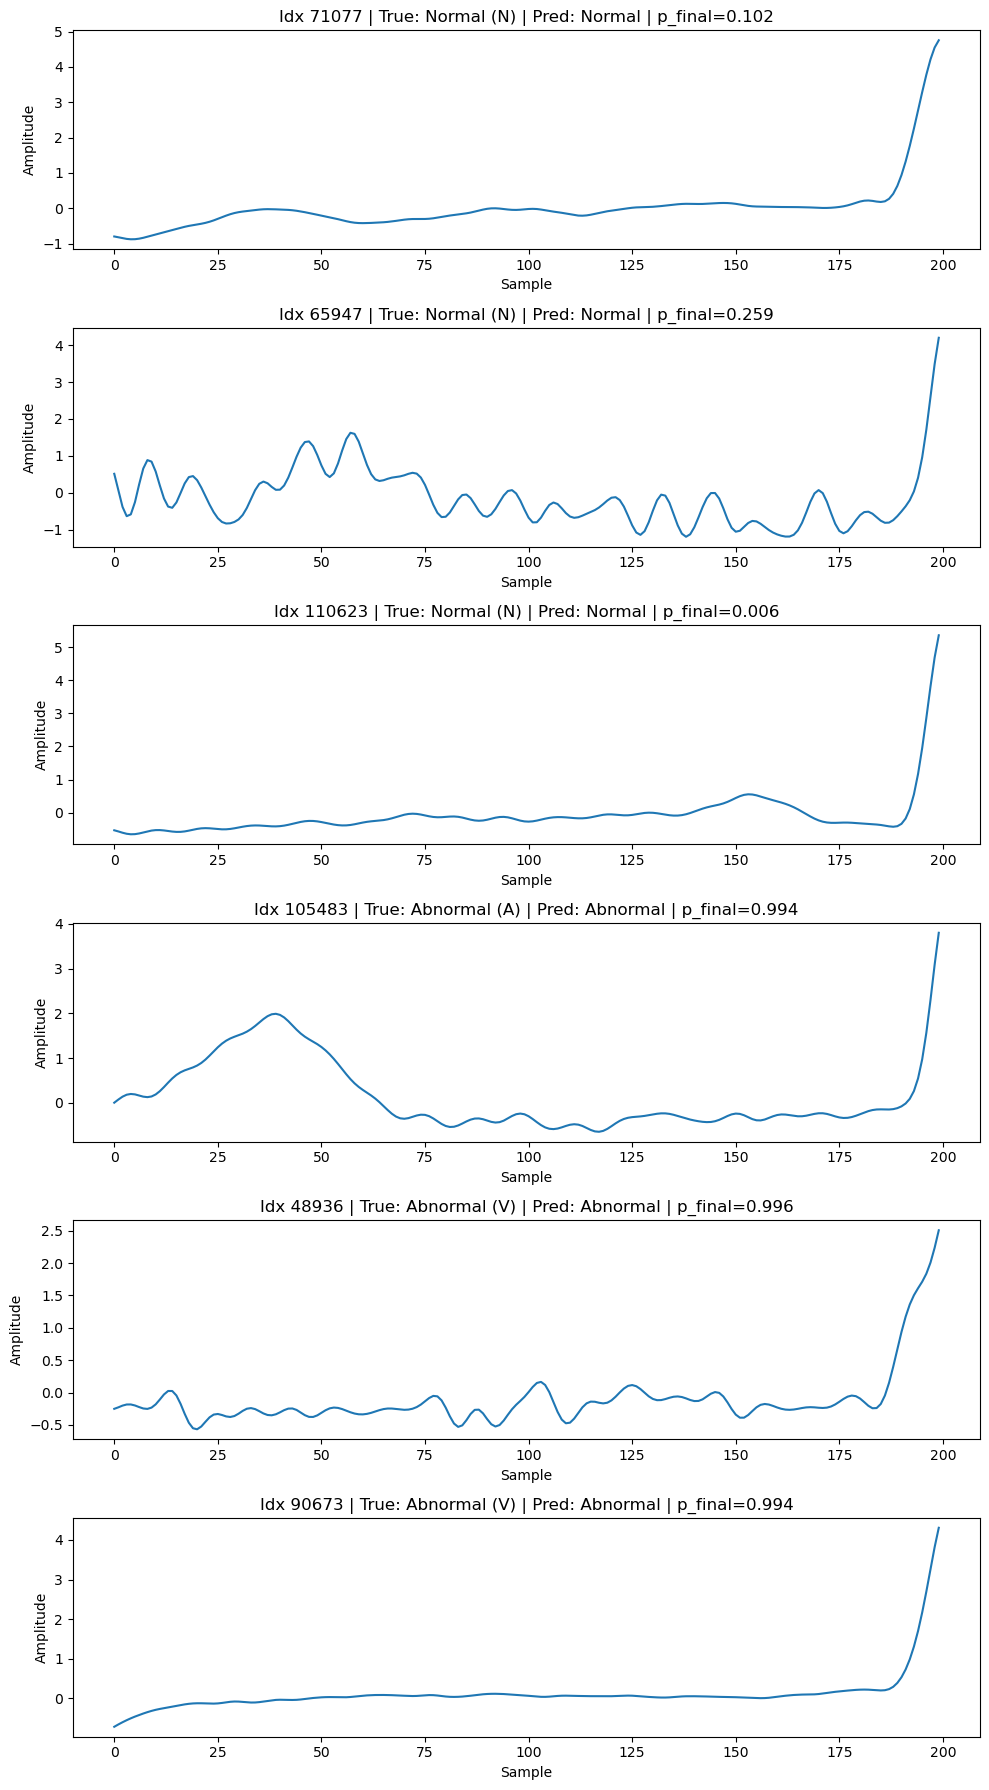


Returned DataFrame:
 index symbol  true_label     p_rf    p_xgb    p_lgb   p_meta  p_hybrid  p_final  pred_final true_label_name pred_label_name
 71077      N           0 0.019802 0.005307 0.005526 0.013181  0.190988 0.102084           0          Normal          Normal
 65947      N           0 0.050497 0.016295 0.017729 0.015892  0.501596 0.258744           0          Normal          Normal
110623      N           0 0.009548 0.003737 0.001439 0.012332  0.000008 0.006170           0          Normal          Normal
105483      A           1 0.890089 0.940965 0.967938 0.988557  1.000000 0.994279           1        Abnormal        Abnormal
 48936      V           1 0.920702 0.937496 0.990379 0.991428  0.999814 0.995621           1        Abnormal        Abnormal
 90673      V           1 0.972584 0.935288 0.963401 0.991497  0.996960 0.994228           1        Abnormal        Abnormal


In [23]:
if __name__ == "__main__":
    CSV_PATH = "mitbih_final_complete_features.csv"
    ARTIFACTS_PATH = os.path.join("saved_models", "artifacts.json")

    df_results = test_saved_models_on_samples(
        csv_path=CSV_PATH,
        artifacts_path=ARTIFACTS_PATH,
        samples_per_class=3,
        raw_signal_len=200,
        random_state=42,
        w_meta=0.5,
        w_hybrid=0.5,
        plot=True
    )
    print("\nReturned DataFrame:")
    print(df_results.to_string(index=False))
